# Introduction to Gaussain Processes for Modelling

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123)

## Inference

We'll demonstrate the use of GPs in modelling the following function $$y = \sin(x) + 5\cos\left(\frac{4x}{5}\right) + 10\tanh(x) + \epsilon$$

In [2]:
def generate_data(X):
    y = np.sin(X) + 5*np.cos(4*X/5) + 10*np.tanh(X) + np.random.normal(loc=0, scale=1)
    return y

### What Does This Look Like?

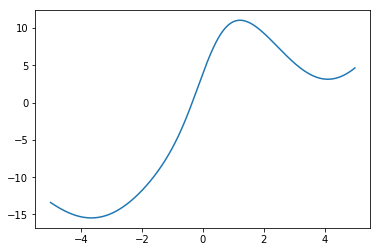

In [3]:
true_X = np.arange(-5, 5, step=0.01).reshape(-1, 1)
true_y = generate_data(true_X)
plt.plot(true_X, true_y)

### Generate Data

In [6]:
n = 20
X_train = np.random.uniform(low=-5, high=5, size=n).reshape(-1, 1)
y_train = generate_data(X_train)
X_test = np.sort(np.random.uniform(low=-5, high=5, size=50).reshape(-1, 1), axis=0)
y_test = generate_data(X_test)

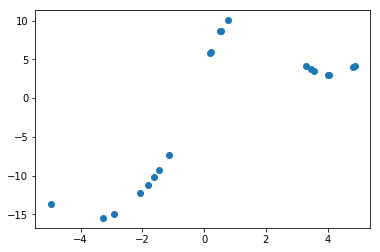

In [7]:
plt.plot(X_train, y_train, 'o')
plt.savefig('observed_data.eps', format='eps', dpi=1200)

### Specify a Kernel

In [8]:
kern = gpflow.kernels.Matern12(input_dim=1)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


### Specify GP

In [9]:
m = gpflow.models.GPR(X_train, y_train, kern)
gpflow.train.ScipyOptimizer().minimize(m)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 39.336812
  Number of iterations: 22
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 39.336812
  Number of iterations: 22
  Number of functions evaluations: 24


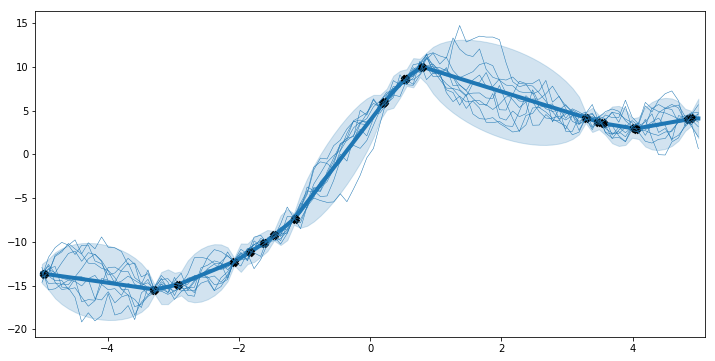

In [10]:
xx = np.linspace(-5, 5, 100).reshape(-1, 1)

mu, var = m.predict_f(xx)
samples = m.predict_f_samples(xx, 10)
## plot 
plt.figure(figsize=(12, 6))
plt.plot(xx, mu, 'C0', lw=4)
plt.plot(X_train, y_train, 'kx', mew=5)
plt.fill_between(xx[:,0],
                mu[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mu[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-5.1, 5.1);

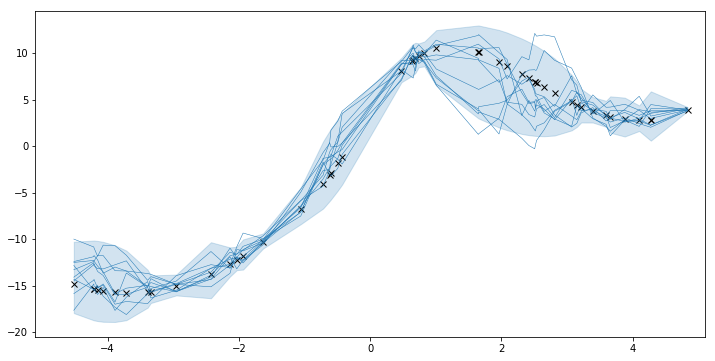

In [13]:
mu, var = m.predict_f(X_test)
samples = m.predict_f_samples(X_test, 10)
## plot 
plt.figure(figsize=(12, 6))
# plt.plot(xx, mu, 'C0', lw=4)
plt.plot(X_test, y_test, 'kx')
# plt.plot(X_train, y_train, 'kx', mew=5)
plt.fill_between(X_test[:,0],
                mu[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mu[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(X_test, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-5.1, 5.1);

In [14]:
np.mean((mu-y_test)**2)

0.6685346878281213

# How Does This Compare to Other Methods?
## Linear Regression

In [15]:
from sklearn import linear_model

reg_lm = linear_model.LinearRegression()
reg_lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
np.mean((reg_lm.predict(X_test)-y_test)**2)

30.875507019446573

## Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(max_depth=5, random_state=123, n_estimators=100)
reg_rf.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

In [18]:
np.mean((reg_rf.predict(X_test)-y_test)**2)

174.22198047000646

## Deep Learning

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [32]:
def create_mlp(dim):
    model = Sequential()
    model.add(Dense(8, input_dim=1, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
 
    return model

In [37]:
nn = create_mlp(X_train.shape[0])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
nn.compile(loss="mean_squared_error", optimizer=opt)

In [38]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

In [40]:
hist = nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=callbacks)

Train on 50 samples, validate on 50 samples
Epoch 1/100
50/50 [==============================] - 0s 4ms/step - loss: 79.3588 - val_loss: 102.0808
Epoch 2/100
50/50 [==============================] - 0s 135us/step - loss: 79.0265 - val_loss: 101.6462
Epoch 3/100
50/50 [==============================] - 0s 91us/step - loss: 78.6814 - val_loss: 101.2080
Epoch 4/100
50/50 [==============================] - 0s 136us/step - loss: 78.3458 - val_loss: 100.7770
Epoch 5/100
50/50 [==============================] - 0s 111us/step - loss: 77.9898 - val_loss: 100.3393
Epoch 6/100
50/50 [==============================] - 0s 86us/step - loss: 77.6318 - val_loss: 99.8998
Epoch 7/100
50/50 [==============================] - 0s 152us/step - loss: 77.3086 - val_loss: 99.4582
Epoch 8/100
50/50 [==============================] - 0s 106us/step - loss: 76.9427 - val_loss: 99.0206
Epoch 9/100
50/50 [==============================] - 0s 141us/step - loss: 76.5881 - val_loss: 98.5796
Epoch 10/100
50/50 [========

In [41]:
np.mean((nn.predict(y_test)-y_test)**2)

36.36919305405847